# Deliverable 3: Optimize the Model

The original model will be tested with each of the following changes made independently. Weights and Model instances will be saved for each.

Optimization Trials: 

1. Add 3rd hidden layer with 15 nodes
2. Decrease neurons in original model
3. Change activation function to Tanh
4. Increase number of bins for APPLICATION_TYPE
5. Drop APPLICATION_TYPE 
6. Additional Neurons per Layer, Additional Layer, Filter for most important Variables, Decrease bins for Class and App type, Stratify data at split.


In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("../Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


## Original Model Preprocessing

In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=['EIN', "NAME"])
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# Determine which values to replace
app_type_counts = application_df['APPLICATION_TYPE'].value_counts()
replace_application = list(app_type_counts[app_type_counts < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [4]:
# Determine which values to replace
class_counts = application_df['CLASSIFICATION'].value_counts()
replace_class = list(class_counts[class_counts < 1500].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [5]:
application_cat = application_df.dtypes[application_df.dtypes == object].index.to_list()
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(application_cat, 1)
application_df.head()

c:\Users\jacob\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
# Split our preprocessed data into our features and target arrays
y = application_df['IS_SUCCESSFUL'].values
X = application_df.drop('IS_SUCCESSFUL', 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

c:\Users\jacob\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Original Model

In [9]:
nn_imported = tf.keras.models.load_model("../models/primary/AlphabetSoupCharity.h5")
model_loss, model_accuracy = nn_imported.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5820 - accuracy: 0.7244 - 310ms/epoch - 1ms/step
Loss: 0.582018256187439, Accuracy: 0.7244315147399902


## 1. Model with 3 layers

In [10]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
n_inputs = len(X_train_scaled[0])
n_nodes_layer1 = 80
n_nodes_layer2 = 30
n_nodes_layer3 = 15
nn_3 = tf.keras.models.Sequential()

# First hidden layer
nn_3.add(tf.keras.layers.Dense(units=n_nodes_layer1, 
        input_dim=n_inputs, activation="relu"))


# Second hidden layer
nn_3.add(tf.keras.layers.Dense(units=n_nodes_layer2, 
        activation="relu"))

# Third hidden layer
nn_3.add(tf.keras.layers.Dense(units=n_nodes_layer3, 
        activation="relu"))

# Output layer
nn_3.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 80)                3520      
                                                                 
 dense_1 (Dense)             (None, 30)                2430      
                                                                 
 dense_2 (Dense)             (None, 15)                465       
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 6,431
Trainable params: 6,431
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Define the checkpoint path and filenames
os.makedirs("../checkpoints/optimized_1",exist_ok=True)
checkpoint_path = "../checkpoints/optimized_1/weights.{epoch:02d}.hdf5"

# Compile the model
nn_3.compile(loss="binary_crossentropy", optimizer="adam", 
            metrics=["accuracy"])

# Create callback to save weights per 5epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=(804*5))

# Train the model
nn_3_fit = nn_3.fit(X_train_scaled,y_train,epochs=100,
        callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 1s 897us/step - loss: 0.5665 - accuracy: 0.7230
Epoch 2/100
804/804 [==============================] - 1s 854us/step - loss: 0.5534 - accuracy: 0.7310
Epoch 3/100
804/804 [==============================] - 1s 839us/step - loss: 0.5499 - accuracy: 0.7325
Epoch 4/100
804/804 [==============================] - 1s 880us/step - loss: 0.5483 - accuracy: 0.7343
Epoch 5/100
786/804 [============================>.] - ETA: 0s - loss: 0.5478 - accuracy: 0.7333
Epoch 5: saving model to ../checkpoints/optimized_1\weights.05.hdf5
804/804 [==============================] - 1s 856us/step - loss: 0.5478 - accuracy: 0.7329
Epoch 6/100
804/804 [==============================] - 1s 850us/step - loss: 0.5466 - accuracy: 0.7344
Epoch 7/100
804/804 [==============================] - 1s 887us/step - loss: 0.5453 - accuracy: 0.7348
Epoch 8/100
804/804 [==============================] - 1s 863us/step - loss: 0.5449 - accuracy: 0.7345
Epoch 9/100
804/804 [==

In [12]:
model_loss, model_accuracy = nn_3.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5869 - accuracy: 0.7247 - 263ms/epoch - 982us/step
Loss: 0.5869457721710205, Accuracy: 0.7246647477149963


In [13]:
# Save the model
os.makedirs("../models/OPTM_1/",exist_ok=True)
nn_3.save("../models/OPTM_1/AlphabetSoupCharity_Optimization1.h5")

## 2. Recreating Original model with decreased neurons per layer

In [14]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
n_inputs = len(X_train_scaled[0])
n_nodes_layer1 = 40
n_nodes_layer2 = 15

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=n_nodes_layer1, 
        input_dim=n_inputs, activation="relu"))


# Second hidden layer
nn.add(tf.keras.layers.Dense(units=n_nodes_layer2, 
        activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 40)                1760      
                                                                 
 dense_5 (Dense)             (None, 15)                615       
                                                                 
 dense_6 (Dense)             (None, 1)                 16        
                                                                 
Total params: 2,391
Trainable params: 2,391
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Define the checkpoint path and filenames
os.makedirs("../checkpoints/optimized_2",exist_ok=True)
checkpoint_path = "../checkpoints/optimized_2/weights.{epoch:02d}.hdf5"

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", 
            metrics=["accuracy"])

# Create callback to save weights per 5epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=(804*5))

In [16]:
# Train the model
nn_fit = nn.fit(X_train_scaled,y_train,epochs=100,
        callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 1s 900us/step - loss: 0.5836 - accuracy: 0.7103
Epoch 2/100
804/804 [==============================] - 1s 927us/step - loss: 0.5553 - accuracy: 0.7298
Epoch 3/100
804/804 [==============================] - 1s 910us/step - loss: 0.5522 - accuracy: 0.7313
Epoch 4/100
804/804 [==============================] - 1s 913us/step - loss: 0.5505 - accuracy: 0.7316
Epoch 5/100
782/804 [============================>.] - ETA: 0s - loss: 0.5491 - accuracy: 0.7333
Epoch 5: saving model to ../checkpoints/optimized_2\weights.05.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5485 - accuracy: 0.7338
Epoch 6/100
804/804 [==============================] - 1s 933us/step - loss: 0.5481 - accuracy: 0.7325
Epoch 7/100
804/804 [==============================] - 1s 937us/step - loss: 0.5469 - accuracy: 0.7327
Epoch 8/100
804/804 [==============================] - 1s 895us/step - loss: 0.5459 - accuracy: 0.7343
Epoch 9/100
804/804 [====

In [17]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5682 - accuracy: 0.7219 - 262ms/epoch - 976us/step
Loss: 0.5681836009025574, Accuracy: 0.7218658924102783


In [18]:
# Save the model
os.makedirs("../models/OPTM_2/",exist_ok=True)
nn.save("../models/OPTM_2/AlphabetSoupCharity_Optimization2.h5")

## 3. Change activation function

In [19]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
n_inputs = len(X_train_scaled[0])
n_nodes_layer1 = 40
n_nodes_layer2 = 15

nn_2 = tf.keras.models.Sequential()

# First hidden layer
nn_2.add(tf.keras.layers.Dense(units=n_nodes_layer1, 
        input_dim=n_inputs, activation="tanh"))


# Second hidden layer
nn_2.add(tf.keras.layers.Dense(units=n_nodes_layer2, 
        activation="tanh"))

# Output layer
nn_2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Define the checkpoint path and filenames
os.makedirs("../checkpoints/optimized_3",exist_ok=True)
checkpoint_path = "../checkpoints/optimized_3/weights.{epoch:02d}.hdf5"

# Compile the model
nn_2.compile(loss="binary_crossentropy", optimizer="adam", 
            metrics=["accuracy"])

# Create callback to save weights per 5epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=(804*5))

# Train the model
nn_2_fit = nn_2.fit(X_train_scaled,y_train,epochs=100,
        callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 1s 912us/step - loss: 0.5718 - accuracy: 0.7212
Epoch 2/100
804/804 [==============================] - 1s 911us/step - loss: 0.5571 - accuracy: 0.7293
Epoch 3/100
804/804 [==============================] - 1s 915us/step - loss: 0.5529 - accuracy: 0.7293
Epoch 4/100
804/804 [==============================] - 1s 890us/step - loss: 0.5507 - accuracy: 0.7313
Epoch 5/100
772/804 [===========================>..] - ETA: 0s - loss: 0.5486 - accuracy: 0.7329
Epoch 5: saving model to ../checkpoints/optimized_3\weights.05.hdf5
804/804 [==============================] - 1s 929us/step - loss: 0.5490 - accuracy: 0.7330
Epoch 6/100
804/804 [==============================] - 1s 991us/step - loss: 0.5477 - accuracy: 0.7319
Epoch 7/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5466 - accuracy: 0.7326
Epoch 8/100
804/804 [==============================] - 1s 890us/step - loss: 0.5459 - accuracy: 0.7346
Epoch 9/100
804/804 [====

In [20]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5614 - accuracy: 0.7236 - 261ms/epoch - 973us/step
Loss: 0.561398983001709, Accuracy: 0.7236151695251465


In [21]:
# Save the model
os.makedirs("../models/OPTM_3/",exist_ok=True)
nn_2.save("../models/OPTM_3/AlphabetSoupCharity_Optimization3.h5")

## Begin reprocessing data for model optimization





## 4. Rebin APPLICATION_TYPE
### Increase number of bins


In [22]:
# reload data
application_df_2 = pd.read_csv("../Resources/charity_data.csv")
# drop EIN and NAME
application_df_2 = application_df_2.drop(columns=['EIN', "NAME"])


In [23]:
# Determine which values to replace
app_type_counts = application_df_2['APPLICATION_TYPE'].value_counts()
replace_application = list(app_type_counts[app_type_counts < 100].index)
# Replace in dataframe
for app in replace_application:
    application_df_2.APPLICATION_TYPE = application_df_2.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df_2.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
T9         156
Other      120
Name: APPLICATION_TYPE, dtype: int64

In [24]:
# Determine which values to replace
class_counts = application_df_2['CLASSIFICATION'].value_counts()
replace_class = list(class_counts[class_counts < 1500].index)

# Replace in dataframe
for cls in replace_class:
    application_df_2.CLASSIFICATION = application_df_2.CLASSIFICATION.replace(cls,"Other")

# Generate our categorical variable lists
application_cat = application_df_2.dtypes[application_df_2.dtypes == object].index.to_list()

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df_2[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)

# Merge one-hot encoded features and drop the originals
application_df_2 = application_df_2.merge(encode_df, left_index=True, right_index=True)
application_df_2 = application_df_2.drop(application_cat, 1)
application_df_2.head()

c:\Users\jacob\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [25]:
# Split our preprocessed data into our features and target arrays
y = application_df_2['IS_SUCCESSFUL'].values
X = application_df_2.drop('IS_SUCCESSFUL', 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

c:\Users\jacob\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
# Define the model
n_inputs = len(X_train_scaled[0])
n_nodes_layer1 = 80
n_nodes_layer2 = 30

nn_new = tf.keras.models.Sequential()

# First hidden layer
nn_new.add(tf.keras.layers.Dense(units=n_nodes_layer1, 
        input_dim=n_inputs, activation="relu"))


# Second hidden layer
nn_new.add(tf.keras.layers.Dense(units=n_nodes_layer2, 
        activation="relu"))

# Output layer
nn_new.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn_new.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 80)                3600      
                                                                 
 dense_11 (Dense)            (None, 30)                2430      
                                                                 
 dense_12 (Dense)            (None, 1)                 31        
                                                                 
Total params: 6,061
Trainable params: 6,061
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Define the checkpoint path and filenames
os.makedirs("../checkpoints/optimized_4",exist_ok=True)
checkpoint_path = "../checkpoints/optimized_4/weights.{epoch:02d}.hdf5"

# Compile the model
nn_new.compile(loss="binary_crossentropy", optimizer="adam", 
            metrics=["accuracy"])

# Create callback to save weights per 5epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=(804*5))

# Train the model
nn_new_fit = nn_new.fit(X_train_scaled,y_train,epochs=100,
        callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 1s 991us/step - loss: 0.5720 - accuracy: 0.7201
Epoch 2/100
804/804 [==============================] - 1s 927us/step - loss: 0.5550 - accuracy: 0.7312
Epoch 3/100
804/804 [==============================] - 1s 906us/step - loss: 0.5518 - accuracy: 0.7308
Epoch 4/100
804/804 [==============================] - 1s 908us/step - loss: 0.5495 - accuracy: 0.7332
Epoch 5/100
774/804 [===========================>..] - ETA: 0s - loss: 0.5480 - accuracy: 0.7334
Epoch 5: saving model to ../checkpoints/optimized_4\weights.05.hdf5
804/804 [==============================] - 1s 930us/step - loss: 0.5479 - accuracy: 0.7335
Epoch 6/100
804/804 [==============================] - 1s 914us/step - loss: 0.5476 - accuracy: 0.7334
Epoch 7/100
804/804 [==============================] - 1s 904us/step - loss: 0.5465 - accuracy: 0.7337
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5462 - accuracy: 0.7338
Epoch 9/100
804/804 [====

In [28]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_new.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5730 - accuracy: 0.7240 - 288ms/epoch - 1ms/step
Loss: 0.5729997158050537, Accuracy: 0.7239649891853333


In [29]:
# Save the model
os.makedirs("../models/OPTM_4/",exist_ok=True)
nn_new.save("../models/OPTM_4/AlphabetSoupCharity_Optimization4.h5")

## 5. Drop APPLICATION_TYPE 

In [30]:
# Reload data
application_df_3 = pd.read_csv("../Resources/charity_data.csv")
# drop EIN and NAME, and APPLICATION_TYPE
application_df_3 = application_df_3.drop(columns=['EIN', "NAME", "APPLICATION_TYPE"])

# Determine which values to replace
class_counts = application_df_3['CLASSIFICATION'].value_counts()
replace_class = list(class_counts[class_counts < 1500].index)

# Replace in dataframe
for cls in replace_class:
    application_df_3.CLASSIFICATION = application_df_3.CLASSIFICATION.replace(cls,"Other")
    
# Get categorical features
application_cat = application_df_3.dtypes[application_df_3.dtypes == object].index.to_list()

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df_3[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)

# Merge one-hot encoded features and drop the originals
application_df_3 = application_df_3.merge(encode_df, left_index=True, right_index=True)
application_df_3 = application_df_3.drop(application_cat, 1)
application_df_3.head()


c:\Users\jacob\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


,STATUS,ASK_AMT,IS_SUCCESSFUL,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
# Split our preprocessed data into our features and target arrays
y = application_df_3['IS_SUCCESSFUL'].values
X = application_df_3.drop('IS_SUCCESSFUL', 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Rebuild model and train with new data
n_inputs = len(X_train_scaled[0])
n_nodes_layer1 = 80
n_nodes_layer2 = 30

nn_new_2 = tf.keras.models.Sequential()

# First hidden layer
nn_new_2.add(tf.keras.layers.Dense(units=n_nodes_layer1, 
        input_dim=n_inputs, activation="relu"))


# Second hidden layer
nn_new_2.add(tf.keras.layers.Dense(units=n_nodes_layer2, 
        activation="relu"))

# Output layer
nn_new_2.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Define the checkpoint path and filenames
os.makedirs("../checkpoints/optimized_5",exist_ok=True)
checkpoint_path = "../checkpoints/optimized_5/weights.{epoch:02d}.hdf5"

# Compile the model
nn_new_2.compile(loss="binary_crossentropy", optimizer="adam", 
            metrics=["accuracy"])

# Create callback to save weights per 5epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=(804*5))

# Train the model
nn_new_2_fit = nn_new_2.fit(X_train_scaled,y_train,epochs=100,
        callbacks=[cp_callback])


Epoch 1/100


c:\Users\jacob\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


804/804 [==============================] - 1s 957us/step - loss: 0.5940 - accuracy: 0.6966
Epoch 2/100
804/804 [==============================] - 1s 937us/step - loss: 0.5811 - accuracy: 0.7084
Epoch 3/100
804/804 [==============================] - 1s 901us/step - loss: 0.5784 - accuracy: 0.7077
Epoch 4/100
804/804 [==============================] - 1s 909us/step - loss: 0.5758 - accuracy: 0.7112
Epoch 5/100
789/804 [============================>.] - ETA: 0s - loss: 0.5755 - accuracy: 0.7126
Epoch 5: saving model to ../checkpoints/optimized_5\weights.05.hdf5
804/804 [==============================] - 1s 911us/step - loss: 0.5752 - accuracy: 0.7128
Epoch 6/100
804/804 [==============================] - 1s 904us/step - loss: 0.5756 - accuracy: 0.7100
Epoch 7/100
804/804 [==============================] - 1s 918us/step - loss: 0.5746 - accuracy: 0.7119
Epoch 8/100
804/804 [==============================] - 1s 958us/step - loss: 0.5740 - accuracy: 0.7114
Epoch 9/100
804/804 [==============

In [32]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_new_2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.6076 - accuracy: 0.7036 - 256ms/epoch - 956us/step
Loss: 0.6076173186302185, Accuracy: 0.7035568356513977


In [33]:
# Save the model
os.makedirs("../models/OPTM_5/",exist_ok=True)
nn_new_2.save("../models/OPTM_5/AlphabetSoupCharity_Optimization5.h5")

## Vizualize feature importance in original model using SHAP.

https://stackoverflow.com/a/61861991

https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models

In [34]:
# Reinstate original data processing
application_df = pd.read_csv("../Resources/charity_data.csv")
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=['EIN', "NAME"])
# Determine which values to replace
app_type_counts = application_df['APPLICATION_TYPE'].value_counts()
replace_application = list(app_type_counts[app_type_counts < 500].index)
# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
# Determine which values to replace
class_counts = application_df['CLASSIFICATION'].value_counts()
replace_class = list(class_counts[class_counts < 1500].index)
# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
application_cat = application_df.dtypes[application_df.dtypes == object].index.to_list()
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))
# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
encode_df.head()
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(application_cat, 1)
# Split our preprocessed data into our features and target arrays
y = application_df['IS_SUCCESSFUL'].values
X = application_df.drop('IS_SUCCESSFUL', 1).values
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# Create a StandardScaler instances
scaler = StandardScaler()
# Fit the StandardScaler
X_scaler = scaler.fit(X_train)
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

c:\Users\jacob\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
c:\Users\jacob\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


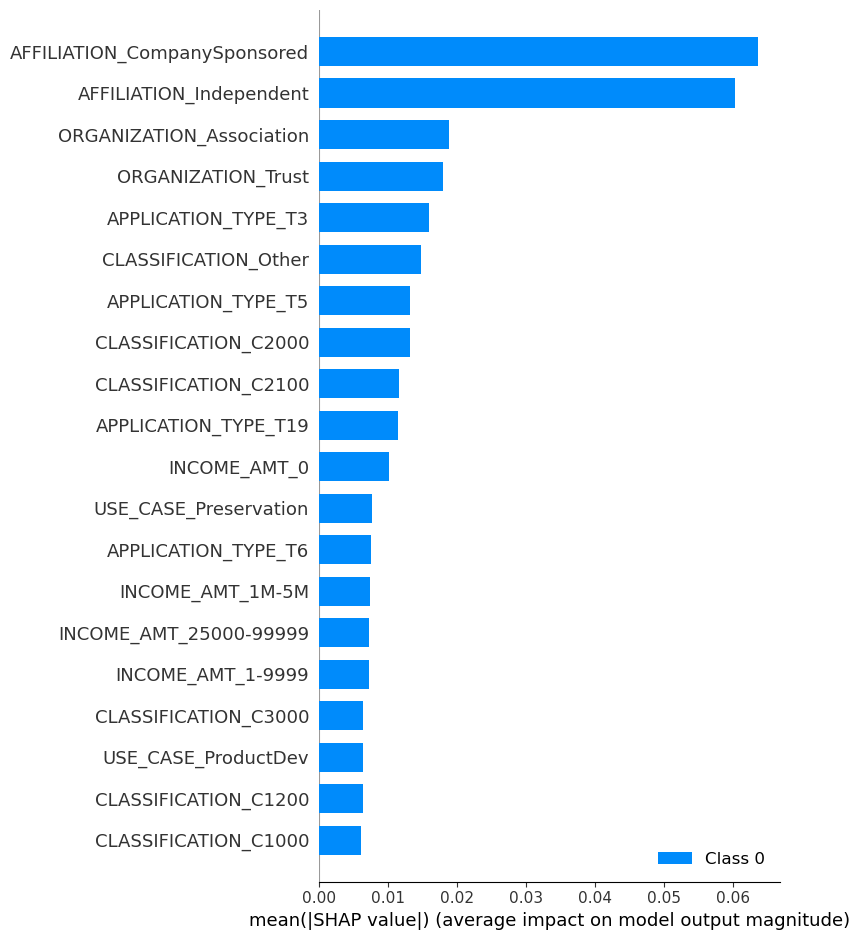

In [35]:
# %pip install shap
import shap

# create feature list
features = list(application_df.drop('IS_SUCCESSFUL', 1).columns)
# load model
model = nn_imported
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.DeepExplainer(model,shap.sample(X_train_scaled, 1000))
shap_values = explainer.shap_values(shap.sample(X_test_scaled, 100))
        # explainer = shap.KernelExplainer(model,X_train_scaled[:1000])
        # shap_values = explainer.shap_values(X_test_scaled[:100])
        # shap_values = explainer.shap_values(X_test_scaled)

# shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_train_scaled[0])

# visualize the explanation
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", feature_names=features)

## 6. Additional Neurons per Layer, Additional Layer, Filter for most important Variables, Decrease bins, stratify data split.
### VARIABLES TO KEEP : ["AFFILIATION", "ORGANIZATION", "CLASSIFICATION", "INCOME_AMT", "USE_CASE", "APPLICATION_TYPE"]

In [36]:
# Reload data
application_df_4 = pd.read_csv("../Resources/charity_data.csv")
# drop EIN and NAME, and APPLICATION_TYPE
application_df_4 = application_df_4[["IS_SUCCESSFUL", "AFFILIATION", "ORGANIZATION", 
        "CLASSIFICATION", "INCOME_AMT", "USE_CASE", "APPLICATION_TYPE"]]


# Determine which values to replace
app_type_counts = application_df_4['APPLICATION_TYPE'].value_counts()
replace_application = list(app_type_counts[app_type_counts < 1000].index)
# Replace in dataframe
for app in replace_application:
    application_df_4.APPLICATION_TYPE = application_df_4.APPLICATION_TYPE.replace(app,"Other")

class_counts = application_df_4['CLASSIFICATION'].value_counts()
replace_class = list(class_counts[class_counts < 5000].index)

# Replace in dataframe
for cls in replace_class:
    application_df_4.CLASSIFICATION = application_df_4.CLASSIFICATION.replace(cls,"Other")
    
# Get categorical features
application_cat = application_df_4.dtypes[application_df_4.dtypes == object].index.to_list()

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df_4[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)

# Merge one-hot encoded features and drop the originals
application_df_4 = application_df_4.merge(encode_df, left_index=True, right_index=True)
application_df_4 = application_df_4.drop(application_cat, 1)
application_df_4.head()
application_df_4.head()

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


,IS_SUCCESSFUL,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,ORGANIZATION_Association,ORGANIZATION_Co-operative,ORGANIZATION_Corporation,...,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6
0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [37]:
# Split our preprocessed data into our features and target arrays
y = application_df_4['IS_SUCCESSFUL'].values
X = application_df_4.drop('IS_SUCCESSFUL', 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y ,random_state=0)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Rebuild model and train with new data
n_inputs = len(X_train_scaled[0])
n_nodes_layer1 = 120
n_nodes_layer2 = 60
n_nodes_layer3 = 30

nn_new_3 = tf.keras.models.Sequential()

# First hidden layer
nn_new_3.add(tf.keras.layers.Dense(units=n_nodes_layer1, 
        input_dim=n_inputs, activation="relu"))


# Second hidden layer
nn_new_3.add(tf.keras.layers.Dense(units=n_nodes_layer2, 
        activation="relu"))

# Second hidden layer
nn_new_3.add(tf.keras.layers.Dense(units=n_nodes_layer3, 
        activation="relu"))

# Output layer
nn_new_3.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Define the checkpoint path and filenames
os.makedirs("../checkpoints/optimized_6",exist_ok=True)
checkpoint_path = "../checkpoints/optimized_6/weights.{epoch:02d}.hdf5"

# Compile the model
nn_new_3.compile(loss="binary_crossentropy", optimizer="adam", 
            metrics=["accuracy"])

# Create callback to save weights per 5epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=(804*5))

# Train the model
nn_new_3_fit = nn_new_3.fit(X_train_scaled,y_train,epochs=100,
        callbacks=[cp_callback])


Epoch 1/100


In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


804/804 [==============================] - 1s 966us/step - loss: 0.5751 - accuracy: 0.7208
Epoch 2/100
804/804 [==============================] - 1s 982us/step - loss: 0.5633 - accuracy: 0.7262
Epoch 3/100
804/804 [==============================] - 1s 980us/step - loss: 0.5617 - accuracy: 0.7275
Epoch 4/100
804/804 [==============================] - 1s 979us/step - loss: 0.5606 - accuracy: 0.7289
Epoch 5/100
802/804 [============================>.] - ETA: 0s - loss: 0.5592 - accuracy: 0.7281
Epoch 5: saving model to ../checkpoints/optimized_6\weights.05.hdf5
804/804 [==============================] - 1s 1ms/step - loss: 0.5591 - accuracy: 0.7282
Epoch 6/100
804/804 [==============================] - 1s 989us/step - loss: 0.5588 - accuracy: 0.7294
Epoch 7/100
804/804 [==============================] - 1s 980us/step - loss: 0.5579 - accuracy: 0.7308
Epoch 8/100
804/804 [==============================] - 1s 994us/step - loss: 0.5568 - accuracy: 0.7303
Epoch 9/100
804/804 [================

In [38]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_new_3.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5756 - accuracy: 0.7273 - 270ms/epoch - 1ms/step
Loss: 0.575575590133667, Accuracy: 0.7273469567298889


In [39]:
# Save the model
os.makedirs("../models/OPTM_6/",exist_ok=True)
nn_new_3.save("../models/OPTM_6/AlphabetSoupCharity_Optimization6.h5")